In [1]:
import json
import os
from os import listdir
from os.path import isfile, join
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tabulate
import numpy as np
import math

from itertools import cycle, islice


In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [3]:
data_dir = join('..', 'data', 'dataset_data')
exp_log_dir = join('..', 'data', 'aggregated_data-incremental_exp_cikm')
out_dir = join('..', 'plots', 'incremental_exp')


appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True


appname = 'BSBM'
data_size_dir = 'BSBM'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False

"""
appname = 'dyldo_y2019_core'
data_size_dir = 'DyLDO-core'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False


appname = 'dyldo_y2019_full'
data_size_dir = 'DyLDO-ext'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False
"""

ticks = 5.0
interpolate = True
include_title = True

clear_name = {'dyldo_y2019_core': 'DyLDO-core'}

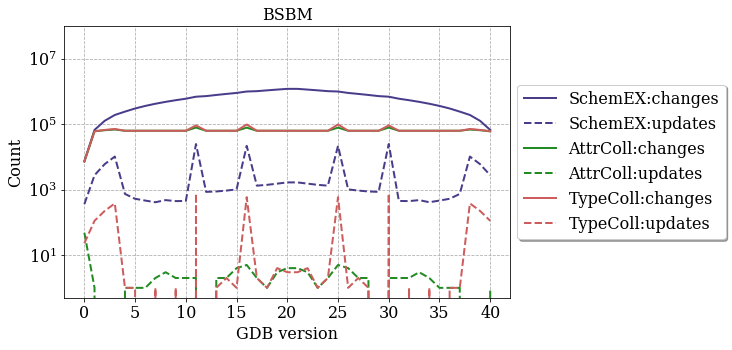

In [4]:
iterations = 0
plot_frame = pd.DataFrame() 
for collection in collections:
    with open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        iterations = max(iterations, len(df))
        f2 = open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r')
        df2 = pd.read_csv(f2, sep=',')
        df2.head()
        
        df2['Imprint links add-del'] = (df2['Imprint links'] - df2['Imprint links'].shift(1,fill_value=0)).abs()
        
        #plot_frame[collection+':change-ratio'] = ((df['ChangedSchemaStructures (SE_mod)'] +  df2['Imprint links add-del']) / (df2['Imprint links'].shift(1,fill_value=0)))
        plot_frame[collection+':changes'] = df['ChangedSchemaStructures (SE_mod)'] +  df2['Imprint links add-del']
        #plot_frame[collection+':update-ratio'] = (df['NewlyObservedSchema (SE_new)'] + df['DeletedSchemaStructures (SE_del)']) / df2['Schema Elements (SE)']
        plot_frame[collection+':updates'] = df['NewlyObservedSchema (SE_new)'] + df['DeletedSchemaStructures (SE_del)']

        
plot_frame.columns = ['SchemEX:changes', 'SchemEX:updates', 
                      'AttrColl:changes', 'AttrColl:updates', 
                      'TypeColl:changes', 'TypeColl:updates']

# this leads to line chart interpolating
# if appname == 'dyldo_y2019_core':
#     plot_frame = plot_frame.drop(plot_frame.index[[21,22]])

if appname == 'dyldo_y2019_core':
    if interpolate:
        plot_frame = plot_frame.drop(plot_frame.index[[21,22]])
    else:
        plot_frame.loc[21:22,'SchemEX:changes':'TypeColl:updates']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    #display(plot_frame)

if appname == 'dyldo_y2019_full':
    plot_frame = plot_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
    
#display(plot_frame)
ax = plot_frame.plot(logy=True, style=['-','--','-','--','-','--'], color=['darkslateblue', 'darkslateblue', 'forestgreen', 'forestgreen', 'indianred', 'indianred'])
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")
if appname.startswith('dyldo'):
    ax.set_ylim([10, 10**7])
else:
    ax.set_ylim(ymax=10**8)

if include_title:
    if appname in clear_name:
        plt.title(clear_name[appname])
    else:
        plt.title(appname)
        
plt.xticks(np.arange(0, iterations, ticks))
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), shadow=True, ncol=1)
plt.grid(True)

if hide_legend:
    ax.get_legend().remove()

plt.savefig(out_dir + '/' + appname + '-change-ratio.pdf', bbox_inches = 'tight')
plt.savefig(out_dir + '/' + appname + '-change-ratio.png', bbox_inches = 'tight', dpi=300)

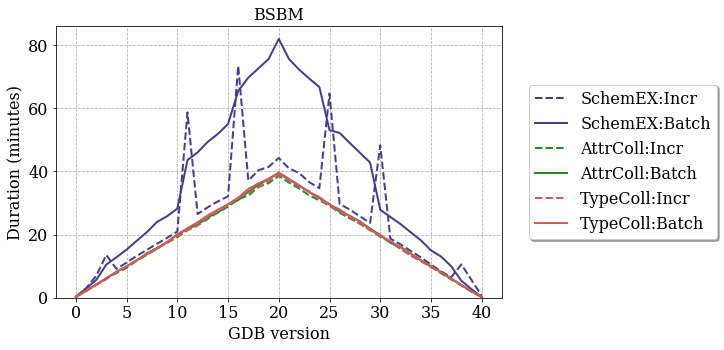

In [5]:
iterations = 0
performance_frame = pd.DataFrame() 
for collection in collections:
    with open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-performance.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        #display(df.head())
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        performance_frame[collection + '-Inc'] = df['Total']
        performance_frame[collection + '-Batch'] = df['Batch']
        
    
    

performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
             'AttrColl:Incr', 'AttrColl:Batch',
             'TypeColl:Incr', 'TypeColl:Batch']


convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
#display(performance_frame)

if appname == 'dyldo_y2019_core':
    if interpolate:
        performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    else:
        performance_frame.loc[21:22,'SchemEX:Incr':'TypeColl:Batch']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    #display(performance_frame)
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
    
ax = performance_frame.plot(logy=False, style = ['--','-','--','-','--','-'], color=['darkslateblue', 'darkslateblue',
                    'forestgreen', 'forestgreen', 'indianred', 'indianred'])
ax.set_xlabel("GDB version")
ax.set_ylabel("Duration (minutes)")

ax.set_ylim(ymin=0)
if appname == 'LUBM':
    ax.set_ylim(ymax=50)
#ax.yaxis.set_label_coords(-0.075,.9)

if include_title:
    if appname in clear_name:
        plt.title(clear_name[appname])
    else:
        plt.title(appname)

plt.xticks(np.arange(0, iterations, ticks))
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), shadow=True, ncol=1)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-performance.pdf', bbox_inches = 'tight')
plt.savefig(out_dir + '/' + appname + '-performance.png', bbox_inches = 'tight', dpi=300)

'../data/dataset_data/BSBM'

['iteration-0.txt',
 'iteration-1.txt',
 'iteration-10.txt',
 'iteration-11.txt',
 'iteration-12.txt',
 'iteration-13.txt',
 'iteration-14.txt',
 'iteration-15.txt',
 'iteration-16.txt',
 'iteration-17.txt',
 'iteration-18.txt',
 'iteration-19.txt',
 'iteration-2.txt',
 'iteration-20.txt',
 'iteration-21.txt',
 'iteration-22.txt',
 'iteration-23.txt',
 'iteration-24.txt',
 'iteration-25.txt',
 'iteration-26.txt',
 'iteration-27.txt',
 'iteration-28.txt',
 'iteration-29.txt',
 'iteration-3.txt',
 'iteration-30.txt',
 'iteration-31.txt',
 'iteration-32.txt',
 'iteration-33.txt',
 'iteration-34.txt',
 'iteration-35.txt',
 'iteration-36.txt',
 'iteration-37.txt',
 'iteration-38.txt',
 'iteration-39.txt',
 'iteration-4.txt',
 'iteration-40.txt',
 'iteration-5.txt',
 'iteration-6.txt',
 'iteration-7.txt',
 'iteration-8.txt',
 'iteration-9.txt']

MAX: 0    14172772
dtype: int64
MIN: 0    75550
dtype: int64


,0
0,75550
1,725305
2,1437571
3,2160862
4,2863155
5,3564773
6,4266578
7,4968357
8,5670080
9,6371827


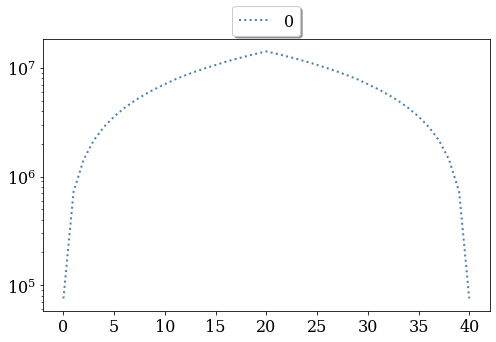

In [6]:
curr_dir = join(data_dir, data_size_dir)
display(curr_dir)
onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
onlyfiles = sorted(onlyfiles)

display(onlyfiles)
edgecounts = {}
tmp = 0
for filename in onlyfiles:
    # first line: number of types in dataset (not unique)
    # second line: number of edges in dataset (not unique)
    f = open(join(curr_dir,filename), 'r')
    content = f.read().split('\n')
    if len(content) > 2:
        edges = int(content[1])
    else:
        edges = int(content[0])
    if 'iteration' in filename:
        iteration = filename.replace('iteration', '')
        iteration = iteration.replace('-', '')
        iteration = iteration.replace('.txt', '')
        iteration = iteration.replace('.gz', '')
        iteration = iteration.replace('.nq', '')
        iteration = iteration.replace('.nt', '')
               
        edgecounts[int(iteration)] = edges
    else:
        edgecounts[tmp] = edges
        tmp = tmp + 1
     
    

edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
edgeframe = pd.DataFrame.sort_index(edgeframe)

if appname == 'dyldo_y2019_core':
    if interpolate:
        edgeframe = edgeframe.drop(edgeframe.index[[21,22]])
    else:
        edgeframe.loc[21:22]=np.nan
 

###
ax = edgeframe.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'],
             color=['steelblue', 'steelblue', 'steelblue', 'steelblue','indianred','indianred','indianred','indianred']) # 'gray',
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
#plt.xticks(np.arange(0, 50, 5.0))
print("MAX: " + str(edgeframe.max()))
print("MIN: " + str(edgeframe.min()))
#display(edgeframe)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), shadow=True, ncol=4)
if hide_legend:
    ax.get_legend().remove()
display(edgeframe)

In [7]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
display(size_frame)


,|V|,schemex:|V_vs|,schemex:|E_vs|,attribute:|V_vs|,attribute:|E_vs|,type:|V_vs|,type:|E_vs|,0
Iteration,,,,,,,,
0,7328,385,3809,49,554,23,0,75550
1,67978,2514,26016,50,569,103,0,725305
2,132776,3750,39761,50,569,135,0,1437571
3,200090,7022,73491,50,569,263,0,2160862
4,263183,7612,81188,51,584,264,0,2863155
5,326247,8011,86436,52,604,265,0,3564773
6,389321,8339,90897,53,622,265,0,4266578
7,452402,8643,94980,55,661,266,0,4968357
8,515472,8950,99199,58,711,266,0,5670080


In [8]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

7328

1286066

630716.1463414634

384445.8299927027

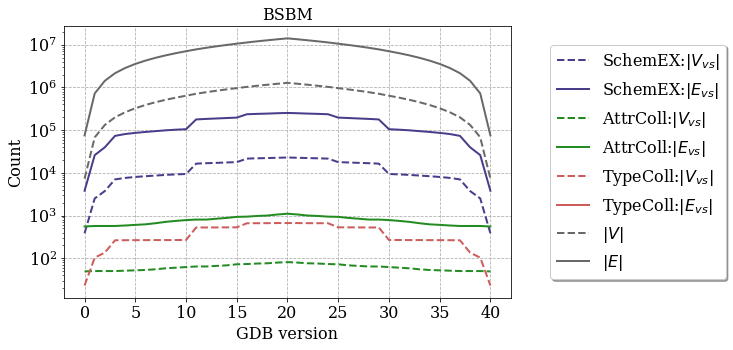

In [9]:
size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']


sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                       color=['darkslateblue', 'darkslateblue',
                             'forestgreen','forestgreen',
                             'indianred','indianred', 'dimgray', 'dimgray'])#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
#ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
#plt.yticks(np.arange(0, iterations, 5.0))

if include_title:
    if appname in clear_name:
        plt.title(clear_name[appname])
    else:
        plt.title(appname)
        
plt.xticks(np.arange(0, iterations, ticks))
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")
if appname.startswith('dyldo'):
    ax.set_ylim([10**3, 10**8*2])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), shadow=True, ncol=1)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)
if hide_legend:
    ax.get_legend().remove()
    
plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')
plt.savefig(out_dir + '/' + appname + '-sizes.png',  bbox_inches = 'tight', dpi=300)